### Basic Concepts: Nodes, Edges & State

In [1]:
from typing import TypedDict
from langgraph.graph import START, END, StateGraph

In [2]:
class InputState(TypedDict):
    msg: str
    num: int

In [3]:
def modify_state(state: InputState):
    print(f"Current state: {state}")
    return state

In [4]:
graph = StateGraph(InputState)

In [5]:
graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)

In [6]:

graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

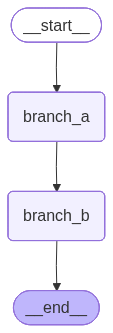

In [7]:
runnable = graph.compile()
runnable

In [8]:
runnable.invoke({"msg": "a"})

Current state: {'msg': 'a'}
Current state: {'msg': 'a'}


{'msg': 'a'}

In [9]:
runnable.invoke({"msg": "a", "num": 1})

Current state: {'msg': 'a', 'num': 1}
Current state: {'msg': 'a', 'num': 1}


{'msg': 'a', 'num': 1}

In [10]:
def modify_state(state: InputState):
    state["msg"] += "a"
    state["num"] += 1
    return state

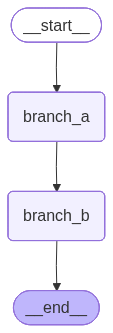

In [11]:
graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)

graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

runnable = graph.compile()
runnable

In [12]:
try:
    runnable.invoke({"msg": "a"})
except Exception as e:
    print(f"Exeption Error: {e}")

Exeption Error: 'num'


In [13]:
runnable.invoke({"msg": "a", "num": 1})

{'msg': 'aaa', 'num': 3}

### Applying LCEL - Langchain

In [14]:
from langchain_core.runnables import RunnableLambda

In [15]:
runnable = RunnableLambda(modify_state)
runnable

RunnableLambda(modify_state)

In [16]:
chain = runnable | runnable
chain

RunnableLambda(modify_state)
| RunnableLambda(modify_state)

In [17]:
chain.invoke({"msg": "a", "num": 1})

{'msg': 'aaa', 'num': 3}

### Cycles and Conditional Edges

In [18]:
def modify_state(state: InputState):
    state["msg"] += "a"
    state["num"] += 1
    return state

def router(state: InputState):
    if state["num"] < 5:
        return "branch_a"
    else:
        return "__end__"

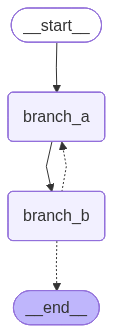

In [19]:
g1 = StateGraph(InputState)

g1.add_node("branch_a", modify_state)
g1.add_node("branch_b", modify_state)

g1.add_edge(START, "branch_a")
g1.add_edge("branch_a", "branch_b")
g1.add_conditional_edges("branch_b", router, {
    "branch_a": "branch_a",
    "__end__": END
})

runnable = g1.compile()
runnable

In [20]:
runnable.invoke({"msg": "a", "num": 1})

{'msg': 'aaaaa', 'num': 5}

### Reducer functions

In [21]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from operator import add

class InputState(TypedDict):
    const_msg: str
    msg: Annotated[str, add]
    num: Annotated[int, add]
    msg_lst: Annotated[list[str], add]

def modify_state(state: InputState):
    print(f"Current state: {state}")
    return state

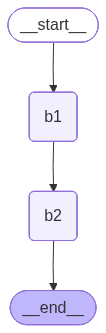

In [22]:
g1 = StateGraph(InputState)

g1.add_node("b1", modify_state)
g1.add_node("b2", modify_state)
g1.add_edge(START, "b1")
g1.add_edge("b1", "b2")
g1.add_edge("b2", END)

runnable = g1.compile()
runnable

In [23]:
runnable.invoke({
    "const_msg": "a",
    "msg": "a",
    "num": 1,
    "msg_lst": ["a"]
})

Current state: {'const_msg': 'a', 'msg': 'a', 'num': 1, 'msg_lst': ['a']}
Current state: {'const_msg': 'a', 'msg': 'aa', 'num': 2, 'msg_lst': ['a', 'a']}


{'const_msg': 'a', 'msg': 'aaaa', 'num': 4, 'msg_lst': ['a', 'a', 'a', 'a']}